In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
sys.path.insert(1,'../../scripts/03_plant_optimization/')

In [4]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../results_samples/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../results_samples/Europe_WGS84.shp')

In [6]:
EU_EFTA = europe_grid.country.unique()

In [7]:
results_path = os.path.join('../../results/02_plant_optimization') # Points to the location of the results csv files

# Import Plant Assumptions

In [8]:
specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

# Import Land Cover Data

In [9]:
countries = europe_grid.country.unique()
lc_path = '../../data/Countries_WGS84/Land_Availability/01_land_scenario'
lc_grid = gpd.GeoDataFrame()
for country in countries:
    lc_grid = lc_grid.append(gpd.read_file(f'{lc_path}/Land_Availability_{country}_AvailLand_Points.shp'))
lc_grid.rename(columns={'name':'country'},inplace=True)
# Correct an error in which the Norway points are given NaN for the country name
lc_grid.loc[lc_grid.country.isna(),'country'] = 'Norway'
lc_grid.crs = europe_grid.crs

# Import LCOF Results

In [10]:
# countries = ['Switzerland','Austria','Germany','France','Italy']
countries = europe_grid.country.unique()
# countries = ['France']
results = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['sea_node'] = False
    df_sea = pd.DataFrame()
    for file_glob in glob(f'{results_path}/offshore/{country}*.csv'): 
        df_sea = df_sea.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df_sea['sea_node'] = True
    df = df.append(df_sea)
    df['country'] = country
    results = results.append(df)
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

In [11]:
lc_grid.head()

,country,lat,lon,avail_area,geometry
0,Austria,47.0,9.375,5.977493,"POLYGON ((9.55984 47.25000, 9.68750 47.25000, ..."
1,Austria,47.5,9.375,0.000000,"POLYGON ((9.68750 47.52951, 9.68750 47.25000, ..."
2,Austria,47.0,10.000,287.090607,"POLYGON ((9.68750 47.25000, 10.31250 47.25000,..."
3,Austria,47.5,10.000,38.654217,"POLYGON ((10.31250 47.30345, 10.31250 47.25000..."
4,Austria,47.0,10.625,368.496521,"POLYGON ((10.31250 47.25000, 10.93750 47.25000..."


<AxesSubplot:>

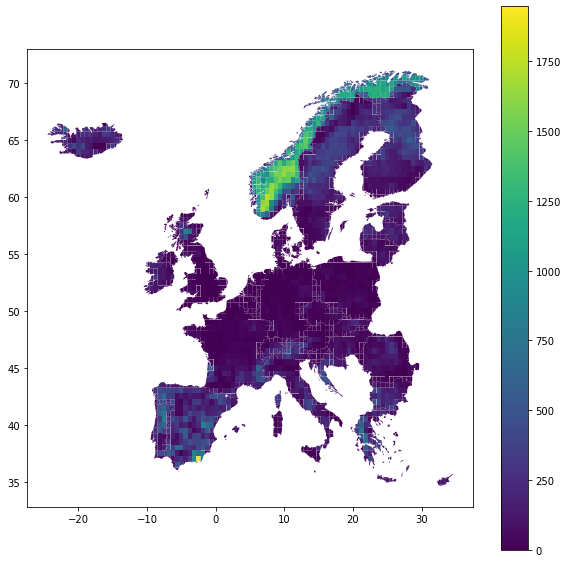

In [12]:
combined = results_gdf.merge(lc_grid[['country','lat','lon','avail_area']],on=['lat','lon','country'],how='left')
combined.plot(column='avail_area',figsize=(10,10),legend=True)

In [13]:
year = 2020
combined['turbine_area_sqkm'] = (combined.rotor_diameter*specs.at['wind_turbine_spacing',f'value_{year}'])**2*combined.wind_turbines/1e6
combined['pv_area_sqkm'] = combined.PV_capacity_MW*1e3/specs.at['PV_peak_per_area',f'value_{year}']/1e6
combined['plant_area_sqkm'] = combined['turbine_area_sqkm'] + combined['pv_area_sqkm']
combined['plants'] = combined.avail_area/combined.plant_area_sqkm
combined['production_GWh'] = combined.plants * specs.at['required_fuel',f'value_{year}']
combined['production_liters'] = combined.production_GWh*3.6e12/specs.at['kerosene_LHV',f'value_{year}']/0.8

<AxesSubplot:>

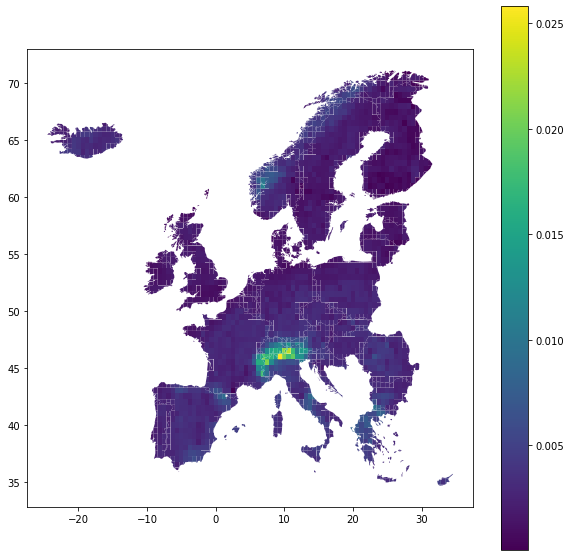

In [14]:
combined.plot(column='pv_area_sqkm',figsize=(10,10),legend=True)

<AxesSubplot:>

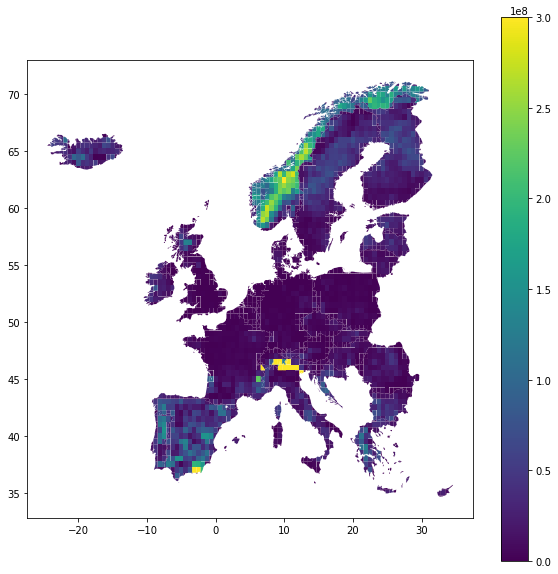

In [15]:
combined.plot(column='production_liters',figsize=(10,10),legend=True,vmax=3e8)

In [18]:
cost_curve = combined.sort_values('LCOF_liter').copy()
cost_curve['production_liters_cumsum'] = cost_curve.production_liters.cumsum()

In [19]:
combined.plants.describe()

count     3102.000000
mean        72.829607
std        829.865425
min          0.000000
25%          1.504051
50%          8.696538
75%         32.196659
max      22244.728265
Name: plants, dtype: float64

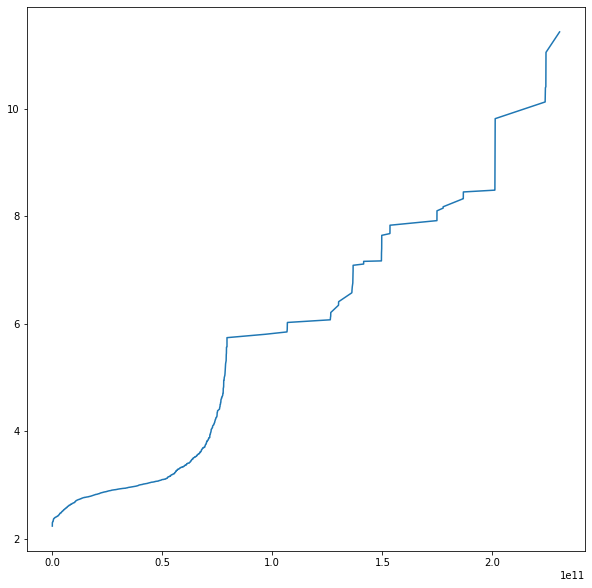

In [23]:
fig,axes = plt.subplots(figsize=(10,10))
axes.plot(cost_curve.production_liters_cumsum,cost_curve.LCOF_liter)
# axes.set_xlim(0,80e9);